# Introduction

In this notebook, we'll evaluate classifiers performing forward and reverse inference using data from neuroimaging articles. *Forward inference* classifiers predict which brain structures were reported in activation coordinate data using the mental functions discussed in article texts. *Reverse inference* classifiers use the same data but flip the inputs and labels, predicting the mental functions in article texts from brain structures in the coordinate data. Classifiers were trained on 12,708 articles, tuned on a validation set of 3,603 articles, and will be evaluated on held-out test set of 1,816 articles. 

Classifiers are multilayer neural networks implemented in PyTorch. All classifiers were trained with ReLU activation functions, 8 layers, and the Adam solver over 500 iterations. The learning rate, weight decay, and number of units per hidden layer were selected based on validation set ROC-AUC.

Evaluation metrics include the following:
1. **ROC-AUC**, which captures the trade-off between true positive rate (TPR) and false positive rate (FPR).
2. **F1 score**, which captures the trade-off between precision and recall (the latter of which is equivalent to the TPR).

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

import sys
sys.path.append("..")
import utilities, evaluation

%matplotlib inline

In [2]:
framework = "dsm"
suffix = "_opsim" # Suffix for term lists
n_iter = 1000 # Iterations for bootstrap and null distributions
alpha = 0.001 # Significance levels for plotting

## Brain activation coordinates

In [3]:
act_bin = utilities.load_coordinates()
print("Document N={}, Structure N={}".format(
      act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=114


## Document-term matrix

In [4]:
dtm_bin = utilities.load_doc_term_matrix(version=190325, binarize=True)
print("Document N={}, Term N={}".format(
      dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=4107


## Framework contents

In [5]:
lists, circuits = utilities.load_framework(framework, suffix=suffix)

## Term list scores

In [6]:
scores = utilities.score_lists(lists, dtm_bin)

# Load classifier fits

## Logistic regression

In [7]:
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ParameterSampler

In [8]:
directions = ["forward", "reverse"]

In [9]:
fit = {}
for direction in directions:
    filename = "logistic_regression/fits/{}_{}.p".format(framework, direction)
    fit[direction] = pickle.load(open(filename, 'rb'))
    print("-"*50 + "\n{} INFERENCE CLASSIFIER\n".format(direction.upper()) + "-"*50)
    print(fit[direction])
    print("")

--------------------------------------------------
FORWARD INFERENCE CLASSIFIER
--------------------------------------------------
OneVsRestClassifier(estimator=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=1e-10,
          verbose=0, warm_start=False),
          n_jobs=1)

--------------------------------------------------
REVERSE INFERENCE CLASSIFIER
--------------------------------------------------
OneVsRestClassifier(estimator=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=1e-10,
          verbose=0, warm_start=False),
          n_jobs=1)



## Neural networks

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
torch.manual_seed(42)

from evaluation import Net

In [11]:
opt_epochs = 500 # Epochs used to optimize the classifier hyperparameters
train_epochs = 1000 # Epochs used to train the classifier

In [13]:
fit_nn = {}
for direction in directions:
    hyperparams = pd.read_csv("neural_network/data/params_{}_{}_{}epochs.csv".format(framework, direction, opt_epochs), header=None, index_col=0)
    h = {str(label): float(value) for label, value in hyperparams.iterrows()}
    state_dict = torch.load("neural_network/fits/{}_{}_{}epochs.pt".format(framework, direction, train_epochs))
    layers = list(state_dict.keys())
    n_input = state_dict[layers[0]].shape[1]
    n_output = state_dict[layers[-2]].shape[0]
    fit_nn[direction] = Net(n_input=n_input, n_output=n_output, 
                         n_hid=int(h["n_hid"]), p_dropout=h["p_dropout"])
    fit_nn[direction].load_state_dict(state_dict)
    print("-"*50 + "\n{} INFERENCE CLASSIFIER\n".format(direction.upper()) + "-"*50)
    print(fit_nn[direction])
    print("")

--------------------------------------------------
FORWARD INFERENCE CLASSIFIER
--------------------------------------------------
Net(
  (fc1): Linear(in_features=9, out_features=25, bias=True)
  (bn1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1)
  (fc2): Linear(in_features=25, out_features=25, bias=True)
  (bn2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.1)
  (fc3): Linear(in_features=25, out_features=25, bias=True)
  (bn3): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.1)
  (fc4): Linear(in_features=25, out_features=25, bias=True)
  (bn4): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.1)
  (fc5): Linear(in_features=25, out_features=25, bias=True)
  (bn5): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d

## Test set

In [14]:
test = [int(pmid.strip()) for pmid in open("../data/splits/test.txt")]
m = len(test)
print("Test N={}".format(m))

Test N=1816


# Load the palette

In [15]:
palette = {"forward": [],
           "reverse": utilities.palettes[framework]}

In [16]:
domains = list(circuits.columns)
print(domains)

['DEVELOPMENTAL', 'PSYCHOTIC', 'BIPOLAR', 'DEPRESSIVE', 'ANXIETY', 'OBSESSIVE_COMPULSIVE', 'TRAUMA_STRESSOR', 'DISRUPTIVE', 'SUBSTANCE']


In [17]:
for structure in act_bin.columns:
    dom_idx = np.argmax(circuits.loc[structure].values)
    color = palette["reverse"][dom_idx]
    palette["forward"].append(color)

# Plot ROC and PR curves

## Forward inference

In [18]:
d = "forward"

In [19]:
pred_probs = fit[d].predict_proba(scores.loc[test])
labels = act_bin.loc[test].values

### ROC curves

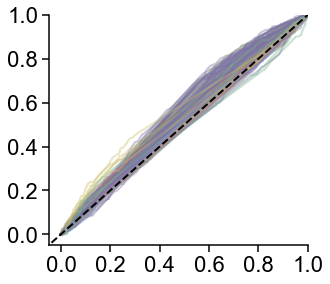

In [20]:
fpr, tpr = evaluation.compute_roc(labels, pred_probs)
evaluation.plot_curves("roc", framework, d, fpr, tpr, palette[d], 
                       opacity=0.4, path="logistic_regression/")

### PR curves

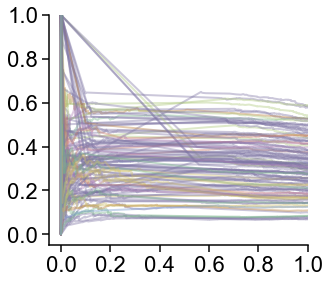

In [21]:
precision, recall = evaluation.compute_prc(labels, pred_probs)
evaluation.plot_curves("prc", framework, d, recall, precision, palette[d], 
                       diag=False, opacity=0.4, path="logistic_regression/")

## Reverse inference

In [22]:
d = "reverse"

In [23]:
pred_probs = fit[d].predict_proba(act_bin.loc[test].values)
labels = scores.loc[test].values

### ROC curves

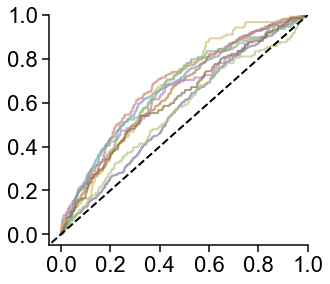

In [24]:
fpr, tpr = evaluation.compute_roc(labels, pred_probs)
evaluation.plot_curves("roc", framework, d, fpr, tpr, palette[d], 
                       opacity=0.65, path="logistic_regression/")

### PR curves

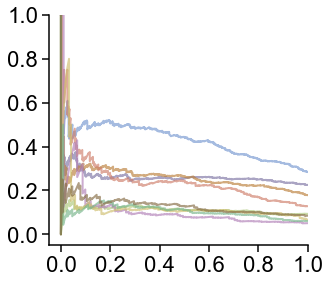

In [25]:
precision, recall = evaluation.compute_prc(labels, pred_probs)
evaluation.plot_curves("prc", framework, d, recall, precision, palette[d], 
                       diag=False, opacity=0.65, path="logistic_regression/")

# Compute evaluation metrics

## Observed values

In [26]:
from sklearn.metrics import roc_auc_score, f1_score

In [27]:
X = {"forward": scores.loc[test].values, "reverse": act_bin.loc[test].values}
Y = {"forward": act_bin.loc[test].values, "reverse": scores.loc[test].values}
pred_probs = {d: fit[d].predict_proba(X[d]) for d in directions}
preds = {d: 1 * (pred_probs[d] > 0.5) for d in directions}

In [28]:
obs = {d: {} for d in directions}
for d in directions:
    obs[d]["rocauc"] = evaluation.compute_eval_metric(Y[d], pred_probs[d], roc_auc_score)
    obs[d]["f1"] = evaluation.compute_eval_metric(Y[d], preds[d], f1_score)

## Bootstrap distributions

In [29]:
import os

In [30]:
boot = {d: {} for d in directions}
for d in directions:
    print("{}".format(d.title()))
    boot[d]["rocauc"] = np.empty((len(obs[d]["rocauc"]), n_iter))
    boot[d]["f1"] = np.empty((len(obs[d]["f1"]), n_iter))
    
    
    rocauc_file = "logistic_regression/data/rocauc_boot_{}_{}_{}iter.csv".format(framework, d, n_iter)
    if os.path.isfile(rocauc_file):
        boot[d]["rocauc"] = pd.read_csv(rocauc_file, index_col=0, header=0).values
        print("\tLoaded ROC-AUC from file")
    else:
        print("ROC-AUC")
        for n in range(n_iter):
            samp = np.random.choice(range(m), size=m, replace=True)
            boot[d]["rocauc"][:,n] = compute_eval_metric(Y[d][samp,:], pred_probs[d][samp,:], roc_auc_score)
            if n % (n_iter/10) == 0:
                print("\tIteration {}".format(n))
    
    
    f1_file = "logistic_regression/data/f1_boot_{}_{}_{}iter.csv".format(framework, d, n_iter)
    if os.path.isfile(f1_file):
        boot[d]["f1"] = pd.read_csv(f1_file, index_col=0, header=0).values
        print("\tLoaded F1 from file")
    else:
        print("F1")
        for n in range(n_iter):
            samp = np.random.choice(range(m), size=m, replace=True)
            boot[d]["f1"][:,n] = compute_eval_metric(Y[d][samp,:], preds[d][samp,:], f1_score)
            if n % (n_iter/10) == 0:
                print("\tIteration {}".format(n))
print("")

Forward
	Loaded ROC-AUC from file
	Loaded F1 from file
Reverse
	Loaded ROC-AUC from file
	Loaded F1 from file



## Null distributions

In [31]:
null = {d: {} for d in directions}
for d in directions:
    print("{}".format(d.title()))
    null[d]["rocauc"] = np.empty((len(obs[d]["rocauc"]), n_iter))
    null[d]["f1"] = np.empty((len(obs[d]["f1"]), n_iter))
    
    
    rocauc_file = "logistic_regression/data/rocauc_null_{}_{}_{}iter.csv".format(framework, d, n_iter)
    if os.path.isfile(rocauc_file):
        null[d]["rocauc"] = pd.read_csv(rocauc_file, index_col=0, header=0).values
        print("\tLoaded ROC-AUC from file")
    else:
        print("ROC-AUC")
        for n in range(n_iter):
            shuf = np.random.choice(range(m), size=m, replace=False)
            null[d]["rocauc"][:,n] = compute_eval_metric(Y[d][shuf,:], pred_probs[d], roc_auc_score)
            if n % (n_iter/10) == 0:
                print("\tIteration {}".format(n))
    
    
    f1_file = "logistic_regression/data/f1_null_{}_{}_{}iter.csv".format(framework, d, n_iter)
    if os.path.isfile(f1_file):
        null[d]["f1"] = pd.read_csv(f1_file, index_col=0, header=0).values
        print("\tLoaded F1 from file")
    else:
        print("F1")
        for n in range(n_iter):
            samp = np.random.choice(range(m), size=m, replace=True)
            null[d]["f1"][:,n] = compute_eval_metric(Y[d][shuf,:], preds[d], f1_score)
            if n % (n_iter/10) == 0:
                print("\tIteration {}".format(n))
print("")

Forward
	Loaded ROC-AUC from file
	Loaded F1 from file
Reverse
	Loaded ROC-AUC from file
	Loaded F1 from file



## Null confidence intervals

In [32]:
interval = 0.999
idx_lower = int((1.0-interval)*n_iter)
idx_upper = int(interval*n_iter)

In [33]:
metric_labels = ["rocauc", "f1"]

In [34]:
null_ci = {d: {} for d in directions}
for metric in metric_labels:
    for d in directions:
        dist = null[d][metric]
        n_clf = dist.shape[0]
        null_ci[d][metric] = {}
        null_ci[d][metric]["lower"] = [sorted(dist[i,:])[idx_lower] for i in range(n_clf)]
        null_ci[d][metric]["upper"] = [sorted(dist[i,:])[idx_upper] for i in range(n_clf)]
        null_ci[d][metric]["mean"] = [np.mean(dist[i,:]) for i in range(n_clf)]

# Perform hypothesis testing

In [35]:
from statsmodels.stats.multitest import multipletests

In [36]:
p = {d: {} for d in directions}
for metric in metric_labels:
    for d in directions:
        dist = null[d][metric]
        n_clf = dist.shape[0]
        p[d][metric] = [np.sum(dist[i,:] >= obs[d][metric][i]) / float(n_iter) for i in range(n_clf)]

In [37]:
fdr = {d: {} for d in directions}
for metric in metric_labels:
    for d in directions:
        fdr[d][metric] = multipletests(p[d][metric], method="fdr_bh")[1]

# Plot evaluation metrics

In [38]:
def plot_eval_metric(metric, framework, direction, obs, boot, null_ci, fdr, 
                     palette, labels=[], dx=0.375, dxs=0.1, figsize=(11,4.5), 
                     ylim=[0.43,0.78], yticks=np.array(range(0,100,5))/100, 
                     alpha=0.001, font=utilities.arial):

    import matplotlib.pyplot as plt
    from matplotlib import font_manager, rcParams

    font_sm = font_manager.FontProperties(fname=font, size=8)
    font_lg = font_manager.FontProperties(fname=font, size=22)
    rcParams["axes.linewidth"] = 1.5
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0,0,1,1])

    # Plot the null distributions
    n_clf = len(obs)
    plt.fill_between(range(n_clf), null_ci["lower"], null_ci["upper"], 
                     alpha=0.2, color="gray")
    plt.plot(null_ci["mean"], 
             linestyle="dashed", color="gray", linewidth=2)

    # Plot the bootstrap distributions
    for i in range(n_clf):
        plt.plot([i-dx, i+dx], [obs[i], obs[i]], 
                 c=palette[i], alpha=1, lw=2, zorder=-1)
        v = ax.violinplot(sorted(boot[i,:]), positions=[i], 
                          showmeans=False, showmedians=False, widths=0.85)
        for pc in v["bodies"]:
            pc.set_facecolor(palette[i])
            pc.set_edgecolor(palette[i])
            pc.set_linewidth(2)
            pc.set_alpha(0.5)
        for line in ["cmaxes", "cmins", "cbars"]:
            v[line].set_edgecolor("none")

        # Comparison test
        if fdr[i] < alpha:
            plt.text(i-dxs, max(boot[i,:]), "*", fontproperties=font_lg)

    ax.set_xticks(range(n_clf))
    ax.set_xticklabels(labels, rotation=60, ha="right")
    plt.xticks(fontproperties=font_sm)
    plt.yticks(yticks, fontproperties=font_lg)
    plt.xlim([-1, n_clf])
    plt.ylim(ylim)
    for side in ["right", "top"]:
        ax.spines[side].set_visible(False)
    ax.xaxis.set_tick_params(width=1.5, length=7)
    ax.yaxis.set_tick_params(width=1.5, length=7)
    n_iter = boot.shape[1]
    plt.savefig("logistic_regression/figures/{}_{}_{}_{}iter.png".format(metric, framework, direction, n_iter), 
                dpi=250, bbox_inches="tight")

## Forward inference

In [39]:
struct_labels = pd.read_csv("../data/brain/labels.csv", index_col=None)
struct_labels.index = struct_labels["PREPROCESSED"]
struct_labels = struct_labels.loc[act_bin.columns, "ABBREVIATION"].values

In [40]:
d = "forward"

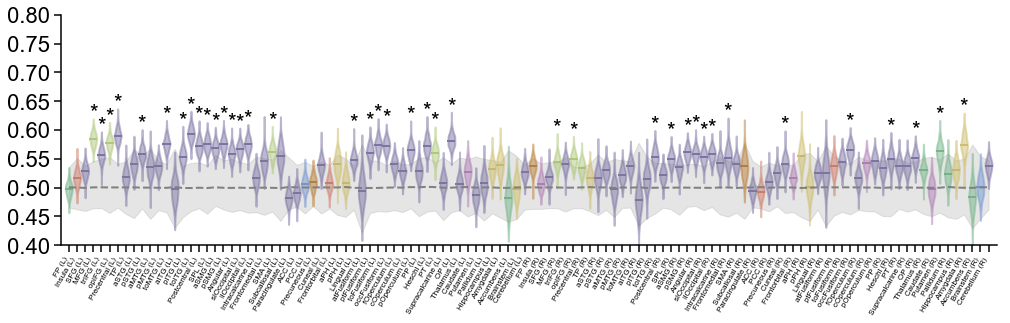

In [41]:
metric = "rocauc"
plot_eval_metric(metric, framework, d, obs[d][metric], 
                 boot[d][metric], null_ci[d][metric], fdr[d][metric],
                 palette[d], labels=struct_labels, dx=0.375, dxs=0.55,
                 figsize=(13, 3.2), ylim=[0.4, 0.8], alpha=alpha)

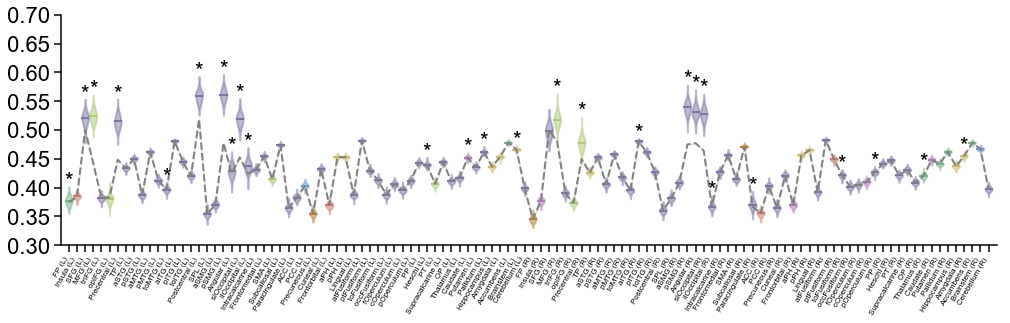

In [42]:
metric = "f1"
plot_eval_metric(metric, framework, d, obs[d][metric], 
                 boot[d][metric], null_ci[d][metric], fdr[d][metric],
                 palette[d], labels=struct_labels, dx=0.375, dxs=0.55,
                 figsize=(13, 3.2), ylim=[0.3, 0.7], alpha=alpha)

## Reverse inference

In [43]:
d = "reverse"

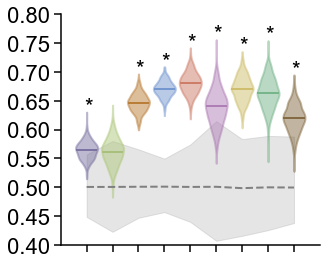

In [44]:
metric = "rocauc"
plot_eval_metric(metric, framework, d, obs[d][metric], 
                 boot[d][metric], null_ci[d][metric], fdr[d][metric],
                 palette[d], labels=[], dx=0.375, dxs=0.11, 
                 figsize=(3.6, 3.2), ylim=[0.4, 0.8], alpha=alpha)

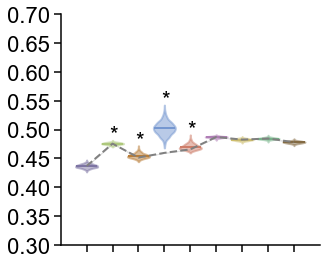

In [45]:
metric = "f1"
plot_eval_metric(metric, framework, d, obs[d][metric], 
                 boot[d][metric], null_ci[d][metric], fdr[d][metric],
                 palette[d], labels=[], dx=0.375, dxs=0.11, 
                 figsize=(3.6, 3.2), ylim=[0.3, 0.7], alpha=alpha)

# Export metric distributions

In [46]:
labels = {"forward": act_bin.columns, "reverse": domains}

In [47]:
for metric in metric_labels:
    for d in directions:
        for dist, dic in zip(["boot", "null"], [boot, null]):
            df = pd.DataFrame(dic[d][metric], 
                              index=labels[d], columns=range(n_iter))
            df.to_csv("logistic_regression/data/{}_{}_{}_{}_{}iter.csv".format(
                      metric, dist, framework, d, n_iter))
        obs_df = pd.Series(obs[d][metric], index=labels[d])
        obs_df.to_csv("logistic_regression/data/{}_obs_{}_{}.csv".format(metric, framework, d))

/Users/ehbeam/anaconda/envs/ontol/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  if __name__ == '__main__':


# Compare to neural networks

In [48]:
boot_nn = {d: {} for d in directions}
for d in directions:
    boot_nn[d]["rocauc"] = pd.read_csv("neural_network/data/rocauc_boot_{}_{}_{}iter.csv".format(framework, d, n_iter), index_col=0, header=0).values
    boot_nn[d]["f1"] = pd.read_csv("neural_network/data/f1_boot_{}_{}_{}iter.csv".format(framework, d, n_iter), index_col=0, header=0).values

In [49]:
lower_i = int(0.001 * n_iter)
upper_i = int(0.999 * n_iter)

for metric in metric_labels:
    for d in directions:
        dist = boot[d][metric] - boot_nn[d][metric]
        dist = [sorted(row) for row in dist]
        lower_CI = [row[lower_i] for row in dist]
        upper_CI = [row[upper_i] for row in dist]
        df = pd.DataFrame({"CI_LOWER": lower_CI, "CI_UPPER": upper_CI})
        df.to_csv("data/{}_lr-nn_{}_{}.csv".format(metric, framework, d), index=None)